## Price vs distance to TTC of rentals on Toronto (Kijiji)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

I am interested in investigating possible relationship between price of rentals in Toronto, and their distance to the closest TTC station. I scrapped hundreds of rental ads from Kijiji (see other notebook). Here is what a typical ad look like:
https://www.kijiji.ca/b-apartments-condos/gta-greater-toronto-area/c37l1700272

Using the Google Map API, I computed the walking time to the closest TTC station, and kept only those rentals with walking time under 60 minutes. 

### Data

In [2]:
df_rentals = pd.read_pickle('Kijiji_rentals25072020.pkl')
len(df_rentals)

1088

In [3]:
df_rentals.head()

,Price,Address,Unit Type,Bedrooms,Bathrooms,Parking Included,Agreement Type,Move-In Date,Pet Friendly,Size (sqft),Furnished,Air Conditioning,Smoking Permitted,Barrier-free Entrances and Ramps,Visual Aids,Accessible Washrooms in Suite,Closest station,Time to closest station
1,1847.0,"765 Steeles Ave West, Toronto, ON, M2R 2S7",nan,nan,nan,0,1 Year,nan,Yes,780.0,No,No,No,nan,nan,nan,Finch,46.333333
3,1797.0,"7433 Yonge St, Thornhill, ON, L3T 1S4",nan,nan,nan,0,1 Year,nan,Yes,NaN,No,No,No,nan,nan,nan,Finch,42.083333
4,2200.0,"185 Roehampton Ave, Toronto, ON M4P 1R4, Canada",nan,nan,nan,1,1 Year,"September 1, 2020",No,654.0,No,Yes,No,No,No,No,Eglinton,9.866667
7,975.0,"10 Livonia Pl, Toronto, ON M1E 4W6, Canada",nan,nan,nan,0,Month-to-month,"August 1, 2020",No,111.0,Yes,Yes,No,nan,nan,nan,McCowan,56.833333
8,3050.0,"250 Wellington St W, Toronto, ON M5V 3P6, Canada",nan,nan,nan,1,1 Year,"September 1, 2020",Yes,1000.0,No,Yes,No,nan,nan,nan,St Andrew,8.133333


In [4]:
details = list(df_rentals.columns)
details = [item for item in details if item not in 
           {'Price', 'Address', 'Closest station', 'Time to closest station', 'Move-In Date', 'Size (sqft)'}]

In [5]:
for detail in details:
    print(detail +': ', '\n', np.unique(df_rentals[detail]), '\n')

Unit Type:  
 ['Apartment' 'Basement' 'Condo' 'House' 'Townhouse' 'nan'] 

Bedrooms:  
 ['1' '1 + Den' '2' '3' '3 + Den' 'Bachelor/Studio' 'nan'] 

Bathrooms:  
 ['1' '1.5' '2' 'nan'] 

Parking Included:  
 ['0' '1' '2' '3+' 'Not Available'] 

Agreement Type:  
 ['1 Year' 'Month-to-month' 'Not Available'] 

Pet Friendly:  
 ['Limited' 'No' 'Not Available' 'Yes'] 

Furnished:  
 ['No' 'Yes'] 

Air Conditioning:  
 ['No' 'Not Available' 'Yes'] 

Smoking Permitted:  
 ['No' 'Not Available' 'Outdoors only' 'Yes'] 

Barrier-free Entrances and Ramps:  
 ['No' 'Not Available' 'Yes' 'nan'] 

Visual Aids:  
 ['No' 'Not Available' 'Yes' 'nan'] 

Accessible Washrooms in Suite:  
 ['No' 'Not Available' 'Yes' 'nan'] 



### Linear regression

In [6]:
def LinReg(X,Y):
    """
    One dimensional linear regression
    X, Y are of shape (-1,1)
    """
    X_0 = np.hstack([np.ones((X.shape[0], 1)), X])
    C = X_0.T @ X_0
    Cinv = (1/np.linalg.det(C))*np.array([[C[1,1], -C[0,1]], [-C[1,0], C[0,0]]])
    # Coeff of Linear regression
    beta = Cinv @ X_0.T @ Y 
    
    s = 0
    for i in range(len(Y)):
        s = s + (Y[i,0] - beta[0] - beta[1]*X[i,0] )**2
    # Empirical variance of additive error, see (3.8) of ESL.    
    sig_tilde = np.sqrt(1/(len(Y) - len(beta))*s)  
    
    # Z-test, see (3.12) of ESL
    z_1 = beta[1]/(sig_tilde*Cinv[1,1])
    
    return beta, sig_tilde, z_1

In [7]:
def statsLinRegRental(x, y, l, hue):
    for item in l:
        df = df_rentals[(df_rentals[hue] == item)]
        if len(df) >3:
            XY = df[[x, y]].values
            XY = XY[np.all(np.isfinite(XY), axis = 1)] # Keep only the data points with no nan's
            X = XY[:,0].reshape(-1,1)
            Y = XY[:,1].reshape(-1,1)
            
            beta, sig_tilde, z_1 = LinReg(X,Y)
            print(item + ': ')
            print('beta = [', beta[0], beta[1], ']')
            print('Z-test for beta[1]: ', z_1, '\n')

### EDA

In [8]:
Price = df_rentals['Price']
Size = df_rentals['Size (sqft)']
Time = df_rentals['Time to closest station']
Type = list(np.unique(df_rentals['Unit Type']))
Bedrooms = list(np.unique(df_rentals['Bedrooms']))
PriceperSqft = Price/Size
df_rentals['Price per sqft'] = PriceperSqft

In [9]:
outliers = df_rentals[(df_rentals['Price per sqft']>10)] # non-sensical size (sqft)
df_rentals = df_rentals[(df_rentals['Price per sqft']<10)]

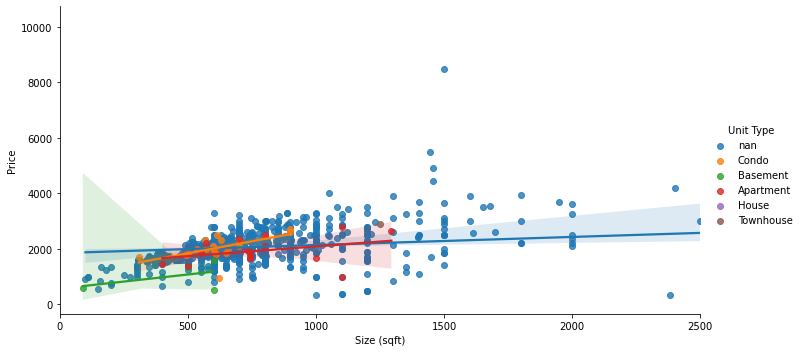

In [10]:
plt.rcParams['figure.figsize'] = [10, 5]
seaborn.lmplot(x = 'Size (sqft)', y = 'Price', data = df_rentals, hue='Unit Type', aspect = 2)
plt.xlim(xmin = -1, xmax = 2500)
plt.show()

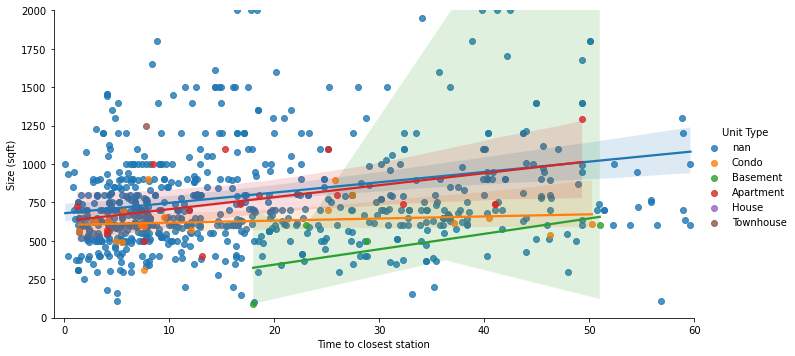

In [11]:
seaborn.lmplot(x = 'Time to closest station', y = 'Size (sqft)', hue='Unit Type', data = df_rentals, aspect = 2)
plt.xlim(xmin = -1, xmax = 60)
plt.ylim(ymin = -1, ymax = 2000)
plt.show()

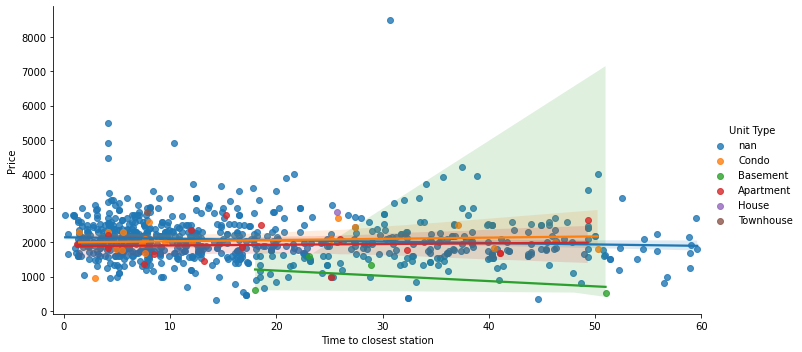

In [12]:
seaborn.lmplot(x = 'Time to closest station', y = 'Price', hue='Unit Type', data = df_rentals, aspect = 2)
plt.xlim(xmin = -1, xmax = 60)
plt.show()

In [13]:
statsLinRegRental('Time to closest station', 'Price', Type, 'Unit Type')

Apartment: 
beta = [ [ 1889.31669557] [ 2.09788883] ]
Z-test for beta[1]:  [ 13.60403892] 

Basement: 
beta = [ [ 1483.83244999] [-15.38522233] ]
Z-test for beta[1]:  [-16.31125311] 

Condo: 
beta = [ [ 1996.91054532] [ 3.57196937] ]
Z-test for beta[1]:  [ 42.51416673] 

nan: 
beta = [ [ 2149.95285166] [-4.1898344] ]
Z-test for beta[1]:  [-1015.89704219] 



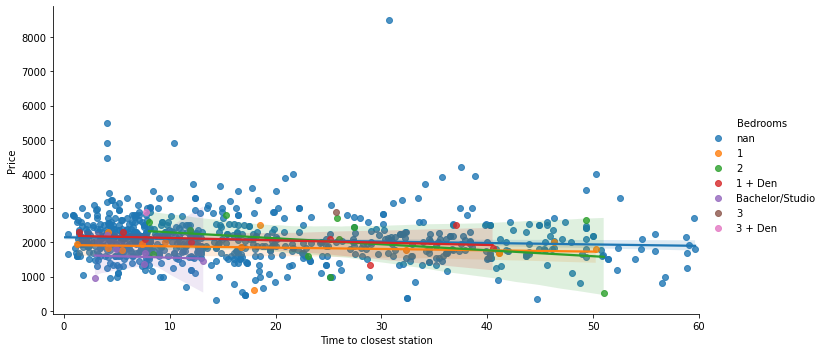

In [14]:
seaborn.lmplot(x = 'Time to closest station', y = 'Price', hue = 'Bedrooms', data = df_rentals, aspect = 2)
plt.xlim(xmin = -1, xmax = 60)
plt.show()

In [15]:
statsLinRegRental('Time to closest station', 'Price', Bedrooms, 'Bedrooms')

1: 
beta = [ [ 1923.94919773] [-3.86303498] ]
Z-test for beta[1]:  [-38.40199651] 

1 + Den: 
beta = [ [ 2197.47425914] [-6.82190633] ]
Z-test for beta[1]:  [-29.82053411] 

2: 
beta = [ [ 2469.8141488] [-17.48232819] ]
Z-test for beta[1]:  [-49.13741317] 

Bachelor/Studio: 
beta = [ [ 1640.1239561] [-8.57215876] ]
Z-test for beta[1]:  [-1.20240568] 

nan: 
beta = [ [ 2149.95285166] [-4.1898344] ]
Z-test for beta[1]:  [-1015.89704219] 



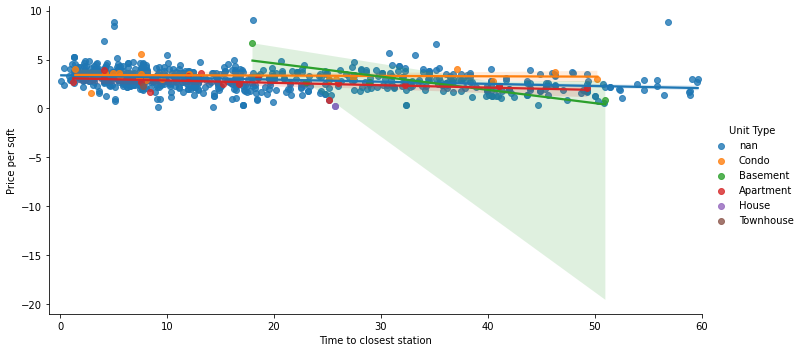

In [16]:
seaborn.lmplot(x = 'Time to closest station', y = 'Price per sqft', hue='Unit Type', data = df_rentals, aspect = 2)
plt.xlim(xmin = -1, xmax = 60)
#plt.ylim(ymin = -1, ymax = 10)
plt.show()

In [17]:
statsLinRegRental('Time to closest station', 'Price per sqft', Type, 'Unit Type')

Apartment: 
beta = [ [ 3.1016083] [-0.02420134] ]
Z-test for beta[1]:  [-115.35236351] 

Basement: 
beta = [ [ 7.33225906] [-0.13580182] ]
Z-test for beta[1]:  [-48.74042293] 

Condo: 
beta = [ [ 3.43269241] [-0.00365202] ]
Z-test for beta[1]:  [-22.55705172] 

nan: 
beta = [ [ 3.38809401] [-0.02186516] ]
Z-test for beta[1]:  [-3555.95550767] 



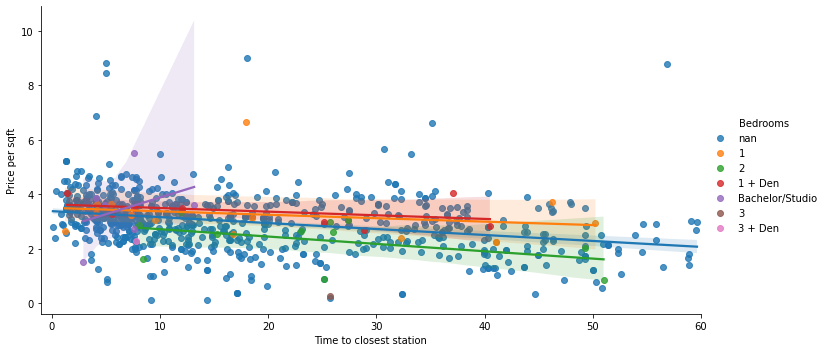

In [18]:
seaborn.lmplot(x = 'Time to closest station', y = 'Price per sqft', hue='Bedrooms', data = df_rentals, aspect = 2)
plt.xlim(xmin = -1, xmax = 60)
#plt.ylim(ymin = -1, ymax = 10)
plt.show()

In [19]:
statsLinRegRental('Time to closest station', 'Price per sqft', Bedrooms, 'Bedrooms')

1: 
beta = [ [ 3.50828944] [-0.01261823] ]
Z-test for beta[1]:  [-48.4716863] 

1 + Den: 
beta = [ [ 3.63617209] [-0.01334317] ]
Z-test for beta[1]:  [-41.30202985] 

2: 
beta = [ [ 2.99522188] [-0.0269681] ]
Z-test for beta[1]:  [-70.99806174] 

Bachelor/Studio: 
beta = [ [ 2.66046649] [ 0.12260476] ]
Z-test for beta[1]:  [ 5.96687381] 

nan: 
beta = [ [ 3.38809401] [-0.02186516] ]
Z-test for beta[1]:  [-3555.95550767] 



#### Linear regression 2

In [20]:
Y = df_rentals['Price']
X = df_rentals[['Size (sqft)', 'Time to closest station']]

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3)

In [22]:
reg = LinearRegression().fit(X_train, Y_train)

In [23]:
reg.coef_

array([ 0.31320539, -6.93960327])

In [24]:
reg.intercept_

1966.2991465963923

In [25]:
reg.score(X_test, Y_test)

0.015080007828426112

In [26]:
reg2 = LinearRegression().fit(X_train[['Size (sqft)']], Y_train)

In [27]:
reg2.coef_

array([ 0.29304823])

In [28]:
reg2.intercept_

1856.9152359290219

In [29]:
reg2.score(X_test[['Size (sqft)']], Y_test)

0.012609447463438062

In [30]:
reg.score(X_test, Y_test)/reg2.score(X_test[['Size (sqft)']], Y_test)

1.1959293119029684

In [31]:
X1_train = X_train[['Size (sqft)']].values
X2_train = X_train[['Time to closest station']].values
Z_train = Y_train.values
X1_test = X_test[['Size (sqft)']].values
X2_test = X_test[['Time to closest station']].values
Z_test = Y_test.values

In [32]:
from mpl_toolkits import mplot3d

In [33]:
def F(x, y):
    return reg.intercept_ + reg.coef_[0]*x + reg.coef_[1]*y

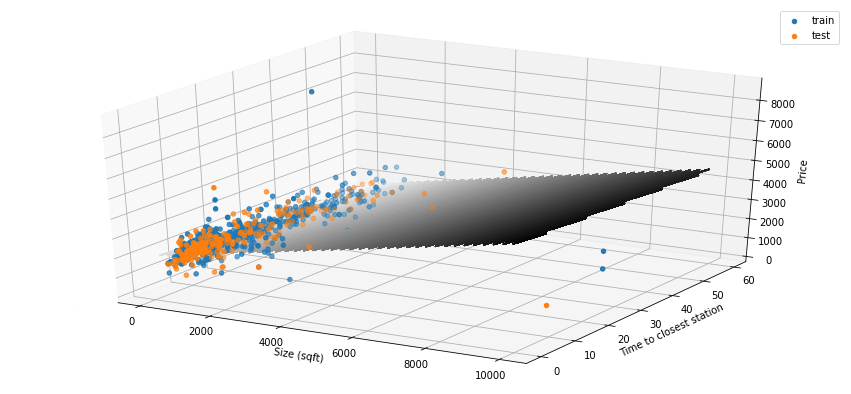

CPU times: user 11.2 s, sys: 122 ms, total: 11.3 s
Wall time: 11.3 s


In [34]:
%%time
plt.rcParams['figure.figsize'] = [15, 7]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X1_train, X2_train, Z_train, label = 'train')
ax.scatter3D(X1_test, X2_test, Z_test, label ='test')

Xm, Ym = np.meshgrid(X1_train, X2_train)
ax.contour3D(Xm, Ym, F(Xm, Ym), 50, cmap='binary')

ax.set_xlabel('Size (sqft)')
ax.set_ylabel('Time to closest station')
ax.set_zlabel('Price')
ax.legend()

plt.show()

### Price per neighbourhood

In [35]:
stops = df_rentals.groupby(['Closest station']).mean()
stops = stops.sort_values(by=['Price per sqft', 'Price'])

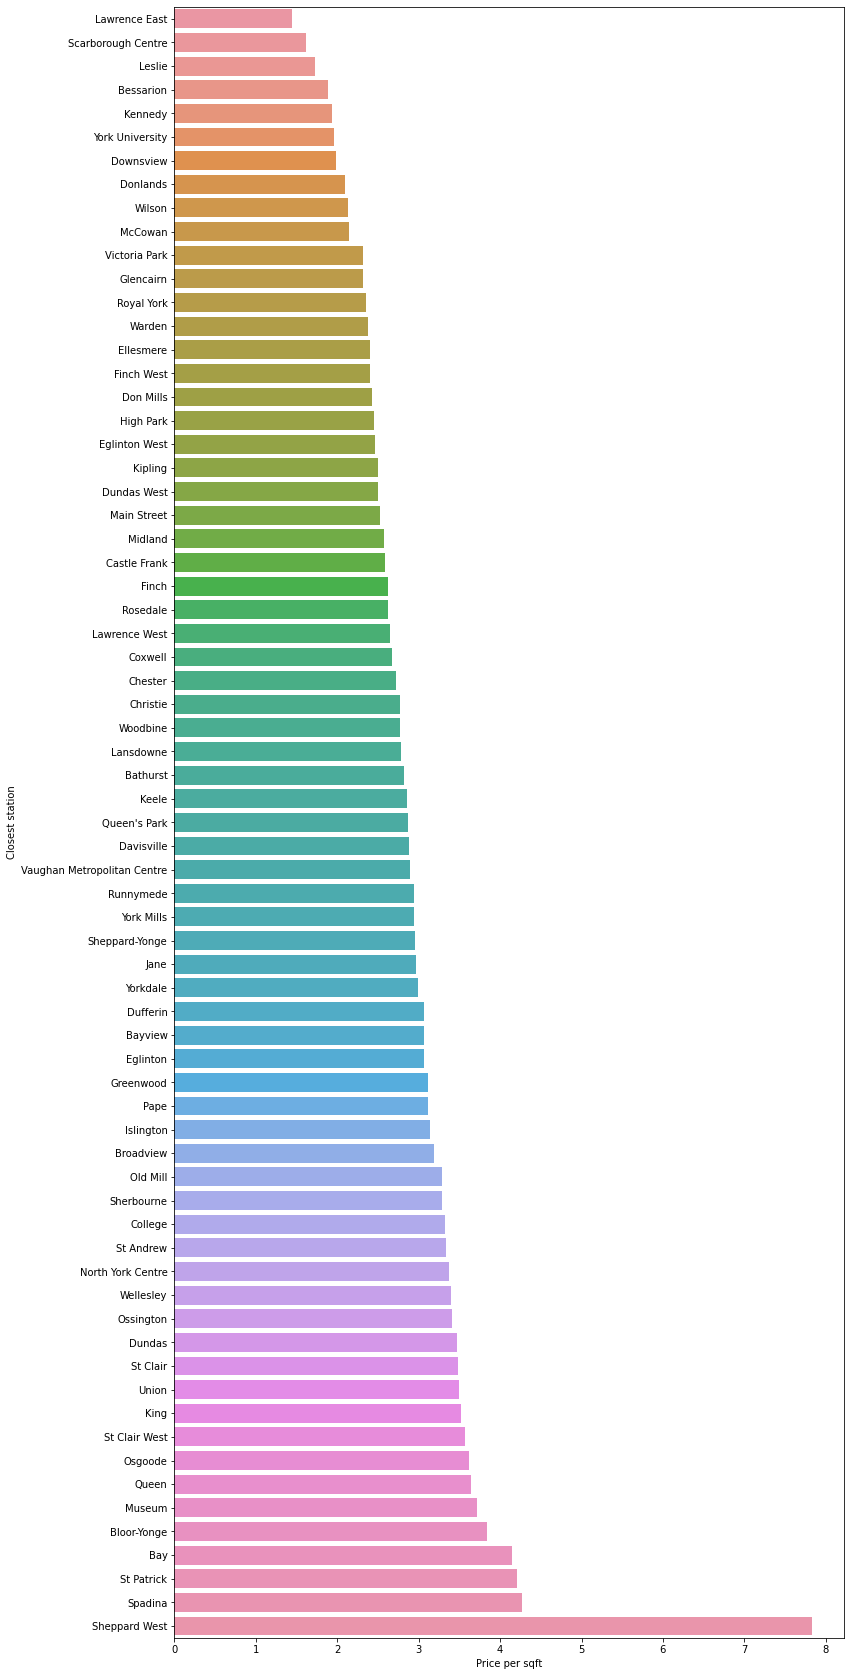

In [36]:
plt.rcParams['figure.figsize'] = [12, 30]
seaborn.set_color_codes("pastel")
seaborn.barplot(y = stops.index, x="Price per sqft", data=stops)
plt.show()

In [38]:
nb = [(len(stops.get_group(station)), station) for station in np.unique(df_rentals['Closest station'])]

AttributeError: 'DataFrame' object has no attribute 'get_group'

In [ ]:
nb.sort()
for n in nb:
    print(n[0], n[1])